### DATA COLLECTION
Dataset: https://www.kaggle.com/shadabhussain/flickr8k

This dataset contains 8000 images each with 5 captions.

In [ ]:
!wget https://www.dropbox.com/s/z76bc5bf7cj7omv/archive.zip?dl=0

In [ ]:
!unzip '/content/flickr8k.zip'

In [ ]:
import os
os.system("kaggle datasets download -d shadabhussain/flickr8k")
os.system("unzip flickr8k.zip -d flickr8k")


In [1]:
!kaggle datasets download -d shadabhussain/flickr8k

^C


### IMPORTING NECESSARY LIBRARIES

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import cv2
import time
import json
from keras.models import Model , Sequential , load_model
from keras.layers import *
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.applications.resnet50 import ResNet50 , preprocess_input , decode_predictions

### UNDERSTANDING THE DATA

In [1]:
def readTextFile(file_path):
    with open(file_path) as f:
     return f.read()

doc = readTextFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

lines = doc.split("\n")[:-1]    # since last line is an empty string
print(len(lines))

40460


In [2]:
lines[80]

'1022454332_6af2c1449a.jpg#0\tA child and a woman are at waters edge in a big city .'

Create a dictionary named “descriptions” which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.

In [3]:
descriptions = {}

for line in lines:

    tokens = line.split('\t')

    # take the first token as image id, the rest as caption
    img_name , caption = tokens[0] , tokens[1]
    img_name = img_name.split('.')[0]

    # if image id is not present in dictionary then initialize it with empty list
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []

    descriptions[img_name].append(caption)

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [4]:
len(descriptions)   # each image id has corresponding 5 captions

8092

### VISUALIZATION

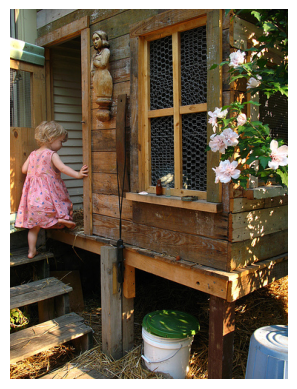

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
img_path = "Flickr_Data/Flickr_Data/Images/"
img = cv2.imread(img_path+'1000268201_693b08cb0e'+'.jpg')
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()
descriptions['1000268201_693b08cb0e']

### DATA CLEANING

In [8]:
def clean_text(sentence):

    # convert to lower case
    sentence = sentence.lower()

    # remove punctuation and numbers from each token
    sentence = re.sub('[^a-z]+' , ' ' , sentence)

    # remove single characters like 's' and 'a'
    sentence = [word for word in sentence.split() if len(word)>1]
    sentence = " ".join(sentence)

    return sentence


for img_id , caption_list in descriptions.items():
    for caption in range(len(caption_list)):
        caption_list[caption] = clean_text(caption_list[caption])

descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

Write all these captions along with their image names in a new file namely, “descriptions.txt” and save it on the disk.

In [13]:
with open("descriptions.txt" , "w") as f:
    f.write(str(descriptions))

In [14]:
with open("descriptions.txt" , "r") as f:
    descriptions = f.read()

type(descriptions)

str

In [16]:
json_acceptable_str = descriptions.replace("'" , "\"")

# loads() method is used to parse a valid JSON string and convert it into a Python Dictionary
descriptions = json.loads(json_acceptable_str)
type(descriptions)

dict

In [17]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

### CREATE VOCAB


In [18]:
total_words = []

for key, caption_list in descriptions.items():
    [total_words.append(word) for caption in caption_list for word in caption.split()]

print("Total no of words across all image captions: %d" %(len(total_words)))

Total no of words across all image captions: 373837


In [19]:
total_words[:10]

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']

In [20]:
unique_words = set()

for key in descriptions.keys():
    [unique_words.update(caption.split()) for caption in descriptions[key]]

print("Total no of unique words across all image captions: %d" %(len(unique_words)))

Total no of unique words across all image captions: 8424


In [21]:
# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
freq_counts = {}

for word in total_words:
    freq_counts[word] = freq_counts.get(word , 0) + 1

print(len(freq_counts.keys()))

8424


In [22]:
# Sort the dictionary according to the frequency count

sorted_freq_count = sorted(freq_counts.items() , reverse = True , key = lambda x:x[1])

In [23]:
print(sorted_freq_count[:10])

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863), ('dog', 8138), ('with', 7765), ('man', 7275), ('of', 6723), ('two', 5643)]


In [24]:
sorted_freq_count = [x for x in sorted_freq_count if x[1] > word_count_threshold]

vocabulary = [x[0] for x in sorted_freq_count]
print("Final Vocab Size: %d" %len(vocabulary))

Final Vocab Size: 1845


### PREPARE THE TRAIN AND TEST DATA

In [25]:
train_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [26]:
train_id = [id.split(".")[0] for id in train_file_data.split("\n")[:-1]]

In [27]:
print("No of Image Id's in Train Data: %d" %len(train_id))

No of Image Id's in Train Data: 6000


In [ ]:
test_file_data[-1]

'\n'

In [28]:
test_id = [id.split(".")[0] for id in test_file_data.split("\n")[:-1]]
print("No of Image Id's in Test Data: %d" %len(test_id))

No of Image Id's in Test Data: 1000


In [29]:
# Prepare descriptions for the training data
# Tweak - Add 'start' and 'end' token to our training data
train_descriptions = {}

for img_id in train_id:
    train_descriptions[img_id] = []

    for caption in descriptions[img_id]:
        caption_to_append = "startseq "+caption+" endseq"
        train_descriptions[img_id].append(caption_to_append)

print("Train Descriptions: %d" %len(train_descriptions))

Train Descriptions: 6000


In [30]:
train_descriptions = {}

for img_id in train_id:
    train_descriptions[img_id] = descriptions.get(img_id)

for key , caption_list in train_descriptions.items():
    for caption in range(len(caption_list)):
        caption_list[caption] = 'startseq ' + caption_list[caption] + ' endseq'

In [30]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### IMAGE PREPROCESSING - Image Features Extraction using Transfer Learning (ResNet-50 Model)


    Image Features Extraction using Transfer Learning (ResNet-50 Model)
    Preprocess Image --> Pass through Resnet Model --> Store the encoded features


In [33]:
model = ResNet50(weights = 'imagenet' , input_shape = (224, 224, 3))
model.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 129s 1us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [34]:
model_new = Model(model.input , model.layers[-2].output)
model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [35]:
def preprocess_image(img):
    img = image.load_img(img , target_size = (224, 224))
    img = image.img_to_array(img)

    # Converted from 3D to a 4D tensor i.e from (224, 224, 3) -- axis=0 --> (1, 224, 224, 3)
    img = np.expand_dims(img , axis = 0)

    # Images are converted from RGB to BGR
    # then each color channel is zero-centered with respect to the ImageNet dataset, without scaling
    img = preprocess_input(img)
    return img

In [39]:
img_path="Flickr_Data/Flickr_Data/Images/"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].


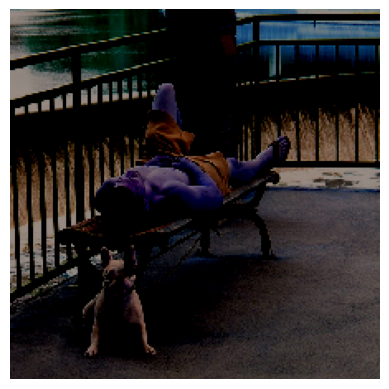

In [40]:
im = preprocess_image(img_path+"1003163366_44323f5815.jpg")
plt.imshow(im[0]/255.0)
plt.axis('off')
plt.show()

In [41]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)           # (1 X 2048)
    feature_vector = feature_vector.reshape((-1, ))
    #print(feature_vector.shape)
    return feature_vector

In [42]:
encode_image(img_path+"1003163366_44323f5815.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([0.1387759 , 0.13362826, 0.21037614, ..., 0.31288385, 0.43862906,
       0.58642817], dtype=float32)

In [43]:
IMG_PATH = 'Flickr_Data/Flickr_Data/Images/'

In [ ]:
start = time.time()
encoded_train_data = {}

for ix, img_id in enumerate(train_id):
    img_path = IMG_PATH + img_id + ".jpg"
    encoded_train_data[img_id] = encode_image(img_path)

    if ix%500 == 0:
        print("Encoding in Progress Step Time %d" %ix)

end = time.time()
print("Time Elapsed: " , end-start)

We will use PICKLE

RAM <=> DISK

for storing data in disk : dump

for loading data in RAM : load

- “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream,
- and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.

In [32]:
with open("encoded_train_img_features.pkl" , "wb") as file:
    pickle.dump(encoded_train_data , file)

In [ ]:
# train_features = pickle.load(open("encoded_train_img_features.pkl", "rb"))
# print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [33]:
start = time.time()
encoded_test_data = {}

for ix, img_id in enumerate(test_id):
    img_path = IMG_PATH + img_id + ".jpg"
    encoded_test_data[img_id] = encode_image(img_path)

    if ix%500 == 0:
        print("Test Encoding in Progress Step Time %d" %ix)

end = time.time()
print("Time Elapsed: " , end-start)

1/1 [==============================] - 0s 84ms/step
Test Encoding in Progress Step Time 0
1/1 [==============================] - 0s 83ms/step
Test Encoding in Progress Step Time 500
1/1 [==============================] - 0s 79ms/step
Time Elapsed:  142.74419617652893


In [34]:
with open("encoded_test_img_features.pkl" , "wb") as file:
    pickle.dump(encoded_test_data , file)

In [35]:
with open("encoded_test_img_features.pkl" , "rb") as f:
    encoded_test_data = pickle.load(f)

### PREPROCESSING CAPTIONS
- We must note that captions are something that we want to predict. So during the training period, captions will be the target variables (Y) that the model is learning to predict.
- But the prediction of the entire caption, given the image does not happen at once. We will predict the caption word by word. Thus, we need to encode each word into a fixed sized vector.

In [36]:
len(vocabulary)

1845

In [37]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(vocabulary):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [38]:
print(word_to_idx['dog'])
print(idx_to_word[6])

6
dog


In [39]:
word_to_idx['startseq'] = 1846
idx_to_word[1846] = 'startseq'

word_to_idx['endseq'] = 1847
idx_to_word[1847] = 'endseq'


# vocab size is len+1 because we will append 0's as well  ;  0th index will be reserved for zero padding
vocab_size = len(word_to_idx) + 1
print("Final Vocab Size: %d" %vocab_size)

Final Vocab Size: 1848


In [40]:
max_len = 0

for key in descriptions.keys():
    for caption in descriptions[key]:
        max_len = max(max_len , len(caption.split()))

print('Max Description Length: %d' %max_len)

Max Description Length: 35


 We can summarize the data matrix for one image and its corresponding caption as follows


 ![image.png](attachment:image.png)

It must be noted that, one image+caption is not a single data point but are multiple data points depending on the length of the caption.

![image.png](attachment:image.png)

### CUSTOM DATA GENERATOR TO LOAD DATA IN BATCHES

In [41]:
# train_descriptions : dictionary with maps image id with its captions for training data
# encoding_train_data : how particular image is mapped to 2048 dimensional feature vector
# word_to_idx : how to convert any given word to index in vocabulary
# max_len : max_len for any sequence in training data
# batch size : how many training examples we want to include in a particular batch

def data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size):

    """X1.append(image vector) , X2.append(partial-captions-input_seq) , y.append(output_seq)"""

    x1 , x2 , y = [] , [] , []
    n = 0

    while True:
        for key, caption_list in train_descriptions.items():
            n += 1

             # retrieve the photo feature
            photo = encoded_train_data[key]

            for caption in caption_list:
                # encode the sequence
                seq = [word_to_idx[word] for word in caption.split() if word in word_to_idx]

                for i in range(1 , len(seq)):
                    # split into input and output pair
                    input_seq , output_seq = seq[0:i] , seq[i]

                    # zero pad input sequence - # accepts a 2-D list and returns a 2-D matrix
                    input_seq = pad_sequences([input_seq], maxlen=max_len, value = 0, padding = 'post')[0]

                    # encode output sequence
                    output_seq = to_categorical([output_seq] , num_classes =  vocab_size)[0]

                    # append training point one by one
                    x1.append(photo)      # 2048 dim
                    x2.append(input_seq)  # 33 dim
                    y.append(output_seq)  # one hot vector of size vocab_size = 1848

            # yield the batch data - generator remembers the state where the function was in previous call
            if n == batch_size:

                yield ([np.array(x1) , np.array(x2)] , np.array(y))   # generator yields a tuple

                # for next function call, when the control comes back again to this generator function, x1, x2 and y
                # will be initialized with empty list because we do not want to add examples of the prev batch
                x1 , x2 , y = [] , [] , []
                n = 0

### WORD EMBEDDINGS [Transfer Learning]
Map the every word (index) to a 50-long vector and for this purpose, we will use a pre-trained GLOVE Model:

In [43]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

Dataset URL: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
License(s): other
 98% 451M/458M [00:03<00:00, 157MB/s]
100% 458M/458M [00:03<00:00, 143MB/s]


In [44]:
! unzip '/content/glove-global-vectors-for-word-representation.zip'

Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [46]:
file = open("glove.6B.100d.txt" , encoding = "utf8")

In [47]:
for line in file:
    print(line)
    break

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062



In [48]:
embeddings_index = {}   # embeddings for 6 billion words

for line in file:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:] , dtype = 'float')
    embeddings_index[word] = word_embedding

file.close()

In [51]:
def get_embedding_matrix():
    emb_dim = 100
    embedding_matrix = np.zeros((vocab_size , emb_dim))

    for idx, word in idx_to_word.items():
        embedding_vector = embeddings_index.get(word)

        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [52]:
embeddings_matrix = get_embedding_matrix()
embeddings_matrix.shape

(1848, 100)

### DEFINE MODEL ARCHITECTURE

In [53]:
# image feature extractor model
input_img_features = Input(shape = (2048,))   # ResNet 50 output
fe1 = Dropout(0.3)(input_img_features)
fe2 = Dense(256, activation='relu')(fe1)   # downsample image vector to 256 dim


# partial caption sequence model
input_captions = Input(shape = (max_len,))  # 33 dim
se1 = Embedding(vocab_size, 100, mask_zero=True)(input_captions)   # we will use pre-initialized embedding matrix
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)    # output text vector is 256 dim

# decoder (feed forward) model - contains info about both image and text vector of 256 dim
decoder1 = add([fe2 , se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)  # predicts prob dist over entire vocab

# merge the two input models - image features and encoded text captions
model = Model(inputs = [input_img_features, input_captions], outputs = outputs)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 100)              184800    ['input_4[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_3[0][0]']             
                                                                                            

In [55]:
model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable = False

In [56]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
plot_model(model, to_file='final_model.png', show_shapes=True)

In [57]:
len(train_descriptions)

6000

### TRAINING

In [58]:
epochs = 10
batch_size = 16
steps_per_epoch = len(train_descriptions)//batch_size

In [59]:
for i in range(epochs):
    generator = data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size)
    model.fit(generator , steps_per_epoch = steps_per_epoch , epochs = 1)

375/375 [==============================] - 105s 280ms/step - loss: 2.7061


In [60]:
j = 11
for i in range(epochs):
    generator = data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size)
    model.fit(generator , steps_per_epoch = steps_per_epoch , epochs = 1)
    model.save('model_weights_'+str(j)+'.h5')
    j += 1

375/375 [==============================] - 105s 281ms/step - loss: 2.6594


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 105s 280ms/step - loss: 2.3928


In [62]:
model.optimizer.lr = 0.0001
epochs = 5
batch_size = 32
steps_per_epoch = len(train_descriptions)//batch_size

In [63]:
for i in range(epochs):
    generator = data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size)
    model.fit(generator , steps_per_epoch = steps_per_epoch , epochs = 1)
    model.save('model_weights_'+str(j)+'.h5')
    j += 1

187/187 [==============================] - 80s 428ms/step - loss: 2.2898


In [64]:
#model = load_model('model_weights_25.h5')
model.load_weights('model_weights_25.h5')

### PREDICTIONS

In [65]:
def predict_caption_using_greedySearch(photo):

    inp_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in inp_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence] , maxlen = max_len , padding = 'post')

        pred_label = model.predict([photo , sequence])
        pred_label = pred_label.argmax()      # Greedy Sampling : Word with max probability always
        pred_word = idx_to_word[pred_label]   # retreiving the word

        inp_text += " " + pred_word    # adding it to the sequence

        # if <e>/end sequence is encountered
        if pred_word == "endseq":
            break

    final_caption = inp_text.split(' ')[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption

1/1 [==============================] - 0s 29ms/step


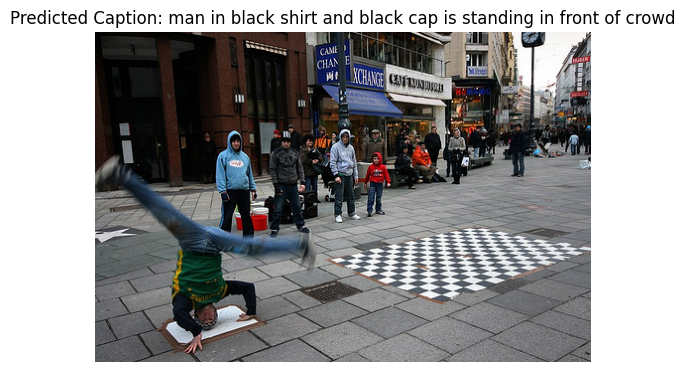

1/1 [==============================] - 0s 28ms/step


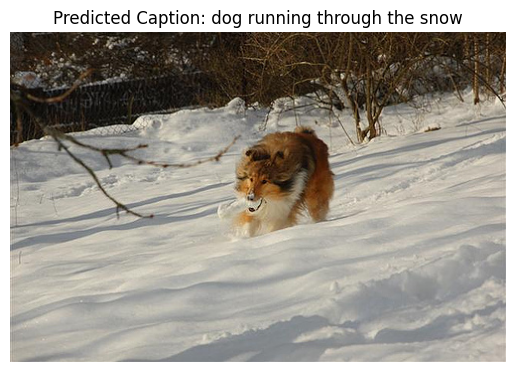

1/1 [==============================] - 0s 29ms/step


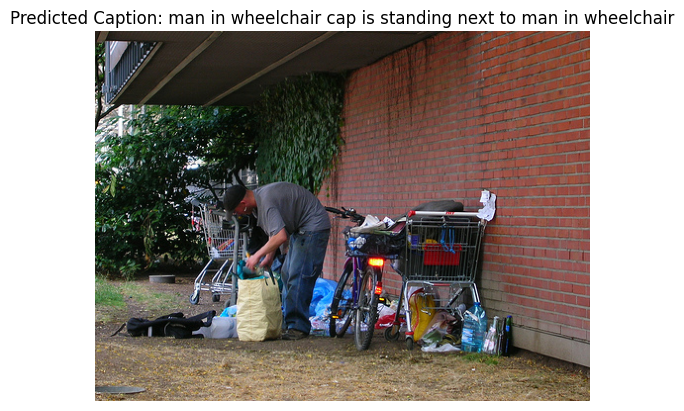

1/1 [==============================] - 0s 32ms/step


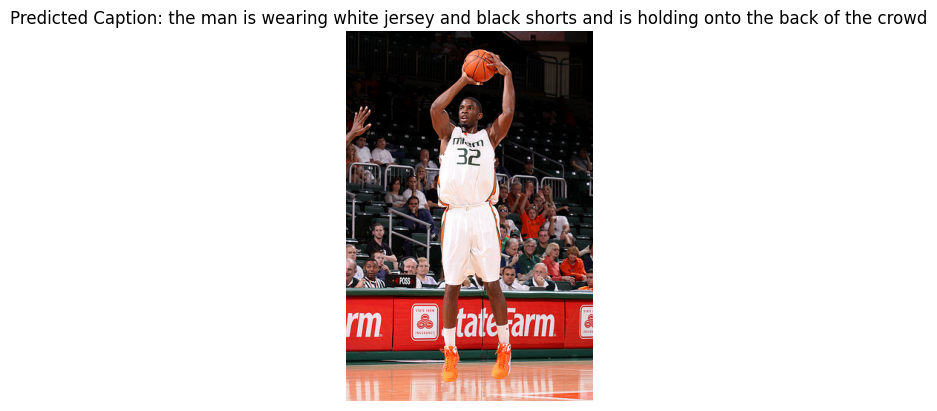

1/1 [==============================] - 0s 33ms/step


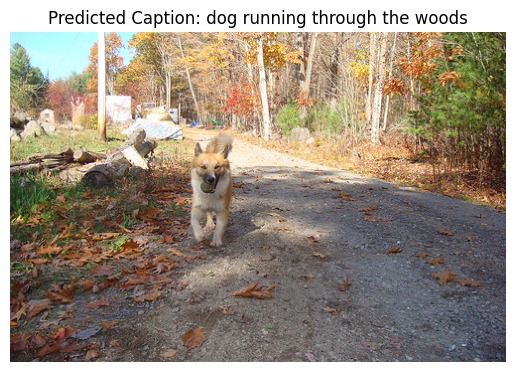

1/1 [==============================] - 0s 31ms/step


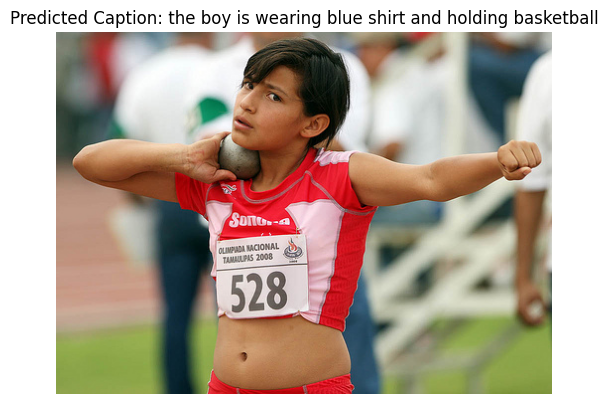

1/1 [==============================] - 0s 30ms/step


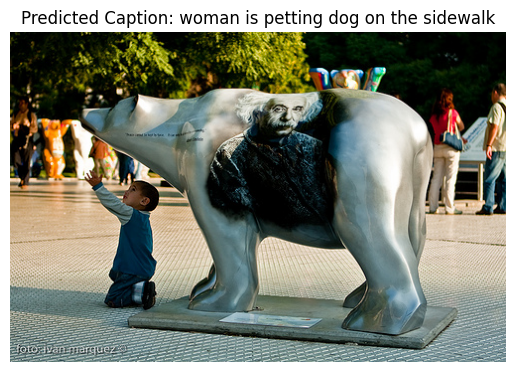

1/1 [==============================] - 0s 30ms/step


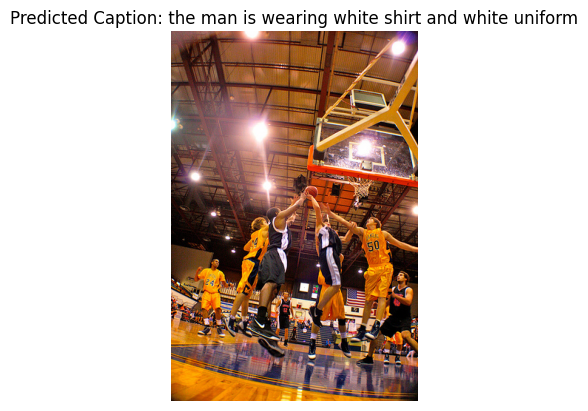

1/1 [==============================] - 0s 29ms/step


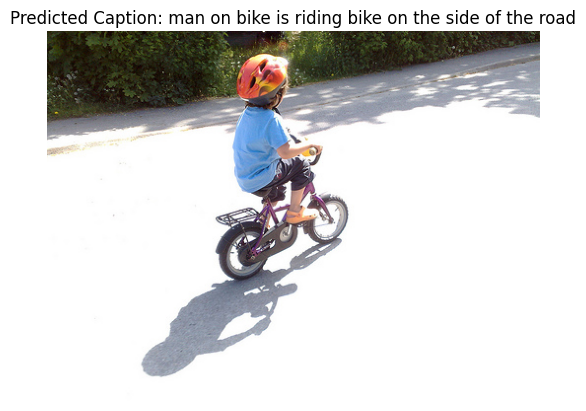

1/1 [==============================] - 0s 32ms/step


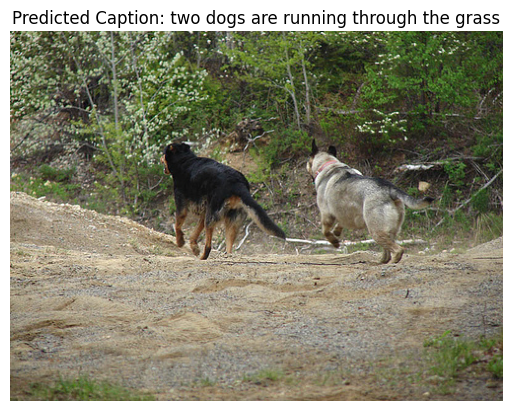

1/1 [==============================] - 0s 32ms/step


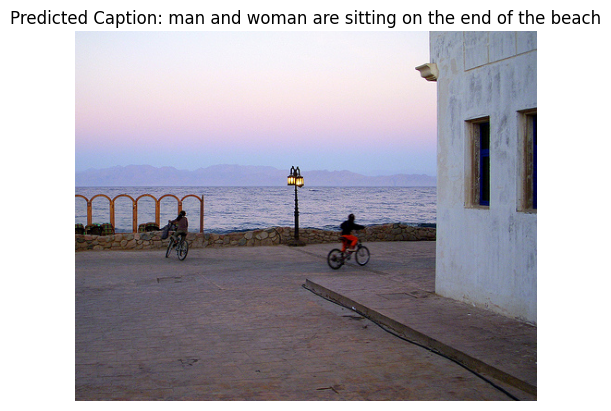

1/1 [==============================] - 0s 29ms/step


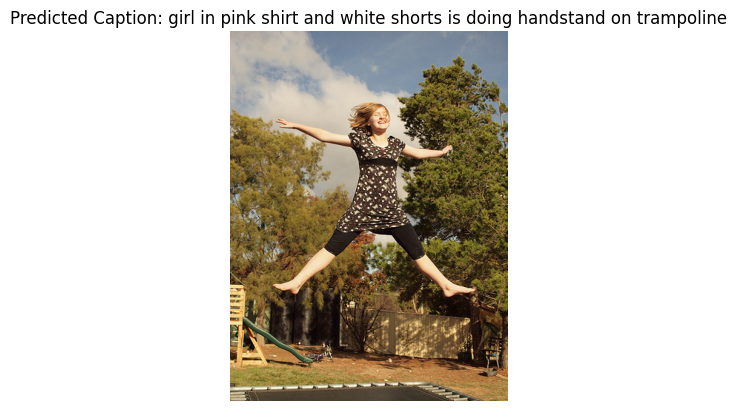

1/1 [==============================] - 0s 30ms/step


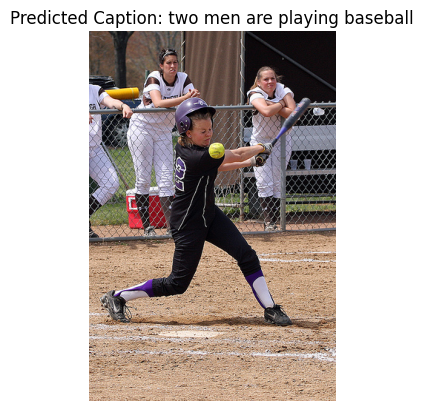

1/1 [==============================] - 0s 28ms/step


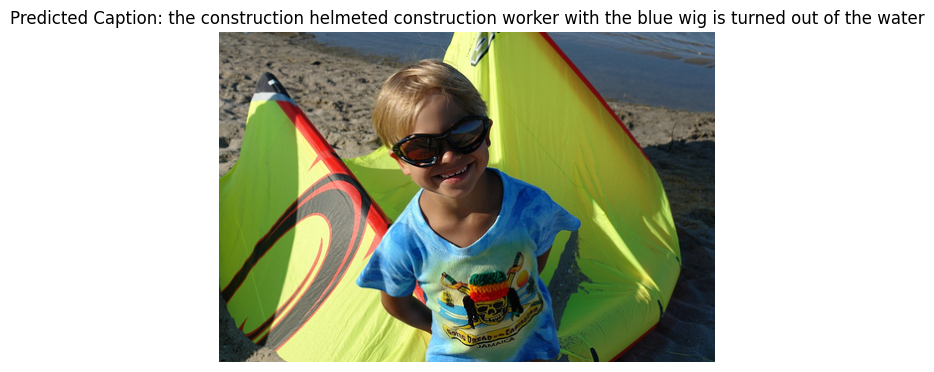

1/1 [==============================] - 0s 28ms/step


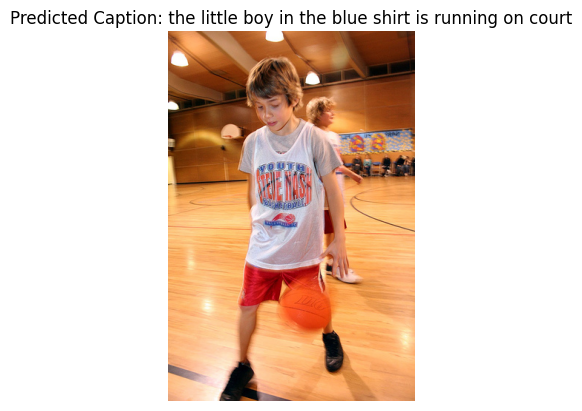

In [66]:
IMG_PATH = 'Flickr_Data/Flickr_Data/Images/'

for i in range(15):
    idx = np.random.randint(0, 1000)

    all_test_images = list(encoded_test_data.keys())
    test_img_id = all_test_images[idx]
    test_img_vec = encoded_test_data[test_img_id].reshape((1, 2048))  # batch size x feature vector

    output_caption = predict_caption_using_greedySearch(test_img_vec)

    img = plt.imread(IMG_PATH + test_img_id + ".jpg")
    plt.imshow(img)
    plt.title("Predicted Caption: " + output_caption)
    plt.axis('off')
    plt.show()